In [1]:
import sys

sys.path.append("C:/Users/junsu/volatility_arbitrage")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt

from volatility_arbitrage.pricing_model.heston_model import generate_inefficient_market
from volatility_arbitrage.pricing_model.interface import HestonParams, MarketModel
from volatility_arbitrage.pricing_model.weighted_variance_swap import (
    StrategyPnlCalculator,
    SkewSwap,
)
from volatility_arbitrage.strategy.evaluation import (
    plot_pnl_distribution,
    plot_pnl_of_path,
    plot_vega_hedge_performance_of_path,
)

# Model Setup

In [3]:
BDAYS = 252

length = BDAYS
time_delta = 1 / length
implied_vol = 0.2
realized_vol = 0.16
num_path = 10_000
rho_tilde = -0.8
rho = -0.6

imp_model = HestonParams(kappa=5, mean_of_var=implied_vol**2, vol_of_var=0.5, rho=rho_tilde)
real_model = HestonParams(kappa=5, mean_of_var=realized_vol**2, vol_of_var=0.5, rho=-0.4)
market_model = MarketModel(
    imp_model=imp_model, real_model=real_model, rho_real_var_imp_var=0.7, rho_spot_imp_var=rho
)

np.random.seed(0)
lr, real_var, imp_var = generate_inefficient_market(
    real_var_0=realized_vol**2,
    imp_var_0=implied_vol**2,
    market_model=market_model,
    num_path=num_path,
    length=length,
    time_delta=time_delta,
)

f = 100 * np.exp(np.cumsum(lr, axis=0))

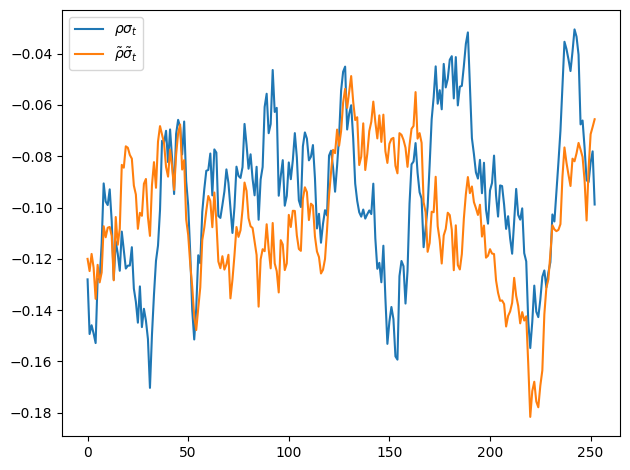

In [4]:
fig, ax = plt.subplots()
ax.plot(rho_tilde * np.sqrt(real_var[:, 0]), label=r"$\rho \sigma_t$")
ax.plot(rho * np.sqrt(imp_var[:, 0]), label=r"$\tilde{\rho} \tilde{\sigma}_t$")
ax.legend()
fig.tight_layout()
plt.show()

- Even though $\rho$ and $\tilde{\rho}$ are fixed, because $\sigma_t$ and $\tilde{\sigma}_t$ change over time, the sign of Vanna P&L changes over time.

# Trading Forward Skew Swap Rolling Everyday

In [5]:
target_dte = np.arange(1, BDAYS + 1, 1)

skew_swap = SkewSwap(market_model=market_model)
skew_swap_pnl_per_dte: dict[int, StrategyPnlCalculator] = {}

for dte in target_dte:
    tau_0 = np.full_like(imp_var[1:], dte / BDAYS)
    tau_1 = np.full_like(imp_var[1:], dte / BDAYS - time_delta)

    pnl_calculator = skew_swap.get_pnl_calculator(
        f_0=f[:-1],
        f_t=f[1:],
        real_var_0=real_var[:-1],
        imp_var_0=imp_var[:-1],
        tau_0=tau_0,
        imp_var_t=imp_var[1:],
        tau_t=tau_1,
    )
    skew_swap_pnl_per_dte[dte] = pnl_calculator

### Continuous Long 1 Month / 1 Day Forward Skewness Swap Strategy (Long Vanna)

In [6]:
cont_long_strategy = np.ones_like(real_var[:-1]) * 10000
cont_long_pnl = skew_swap_pnl_per_dte[21].get_strategy_pnl(
    cont_long_strategy
) - skew_swap_pnl_per_dte[1].get_strategy_pnl(cont_long_strategy)

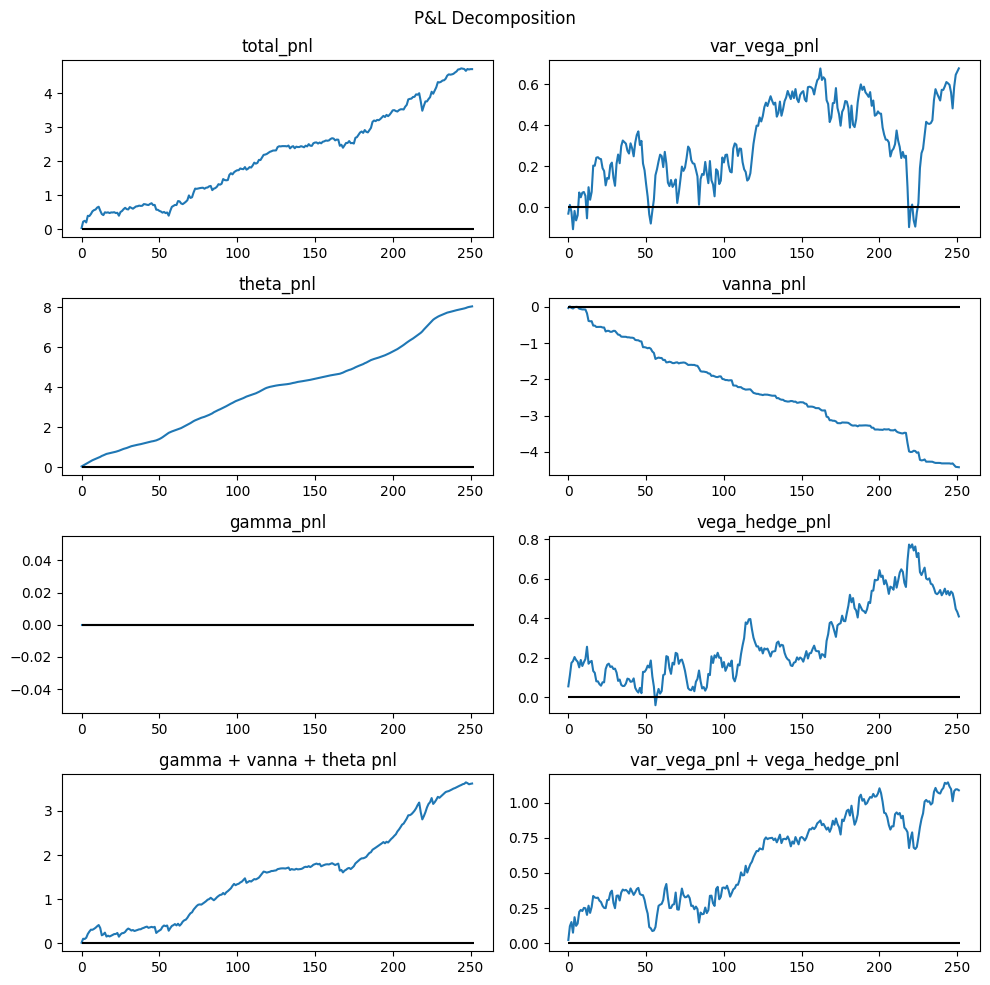

In [7]:
plot_pnl_of_path(cont_long_pnl, 0)

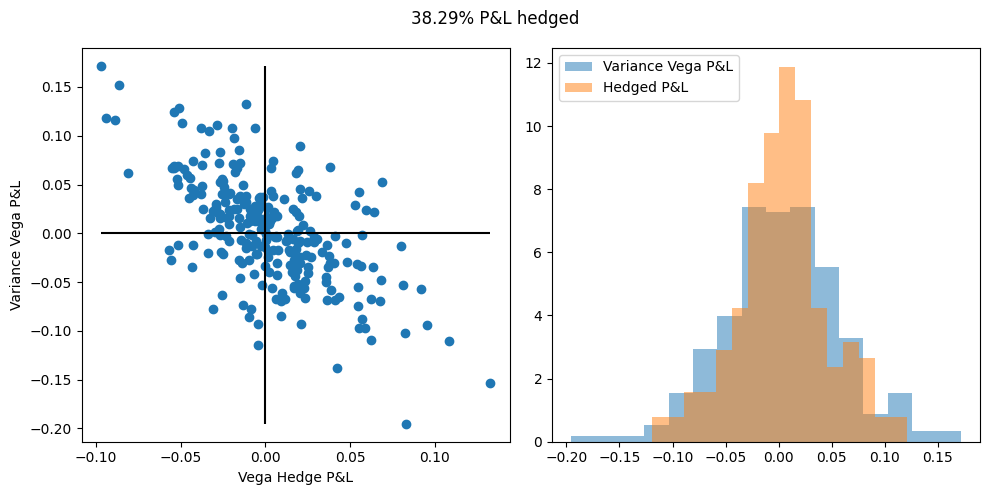

In [8]:
plot_vega_hedge_performance_of_path(cont_long_pnl, 0)

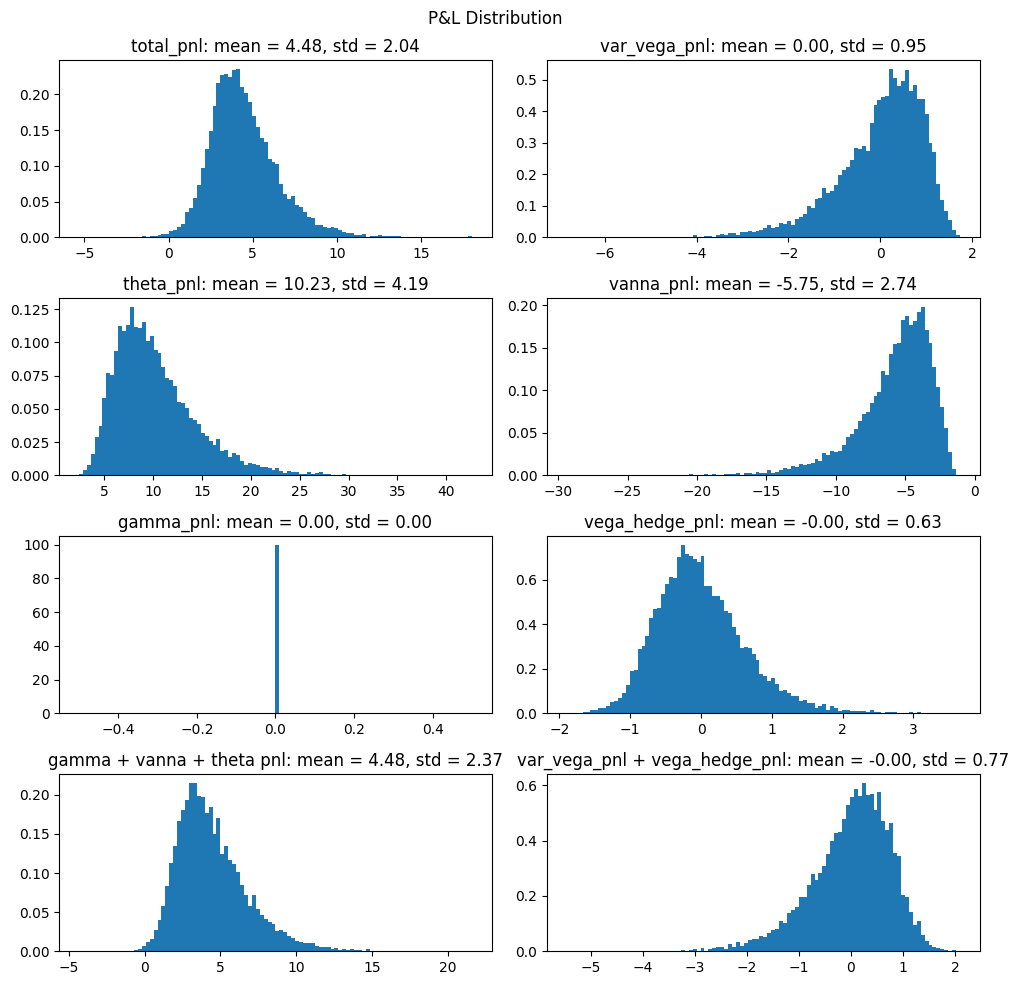

In [9]:
plot_pnl_distribution(cont_long_pnl)

### Skewness Arbitrage Strategy

In [10]:
skew_arb_strategy: npt.NDArray[np.float64] = 10000 * (
    (rho * np.sqrt(real_var[:-1]) > rho_tilde * np.sqrt(imp_var[:-1])).astype(dtype=int) * 2 - 1
)
day_skew_arb_pnl = skew_swap_pnl_per_dte[1].get_strategy_pnl(skew_arb_strategy)
fwd_skew_arb_pnl = skew_swap_pnl_per_dte[21].get_strategy_pnl(skew_arb_strategy) - day_skew_arb_pnl

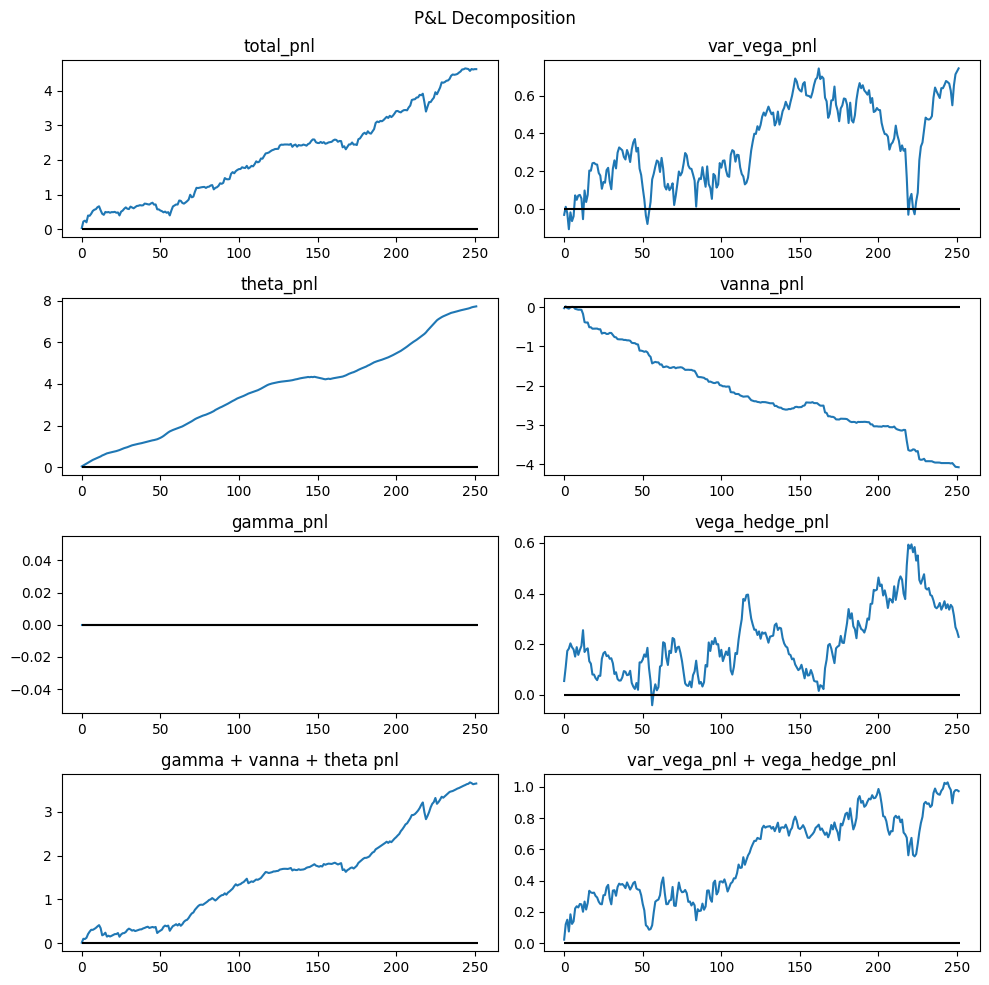

In [11]:
plot_pnl_of_path(fwd_skew_arb_pnl, 0)

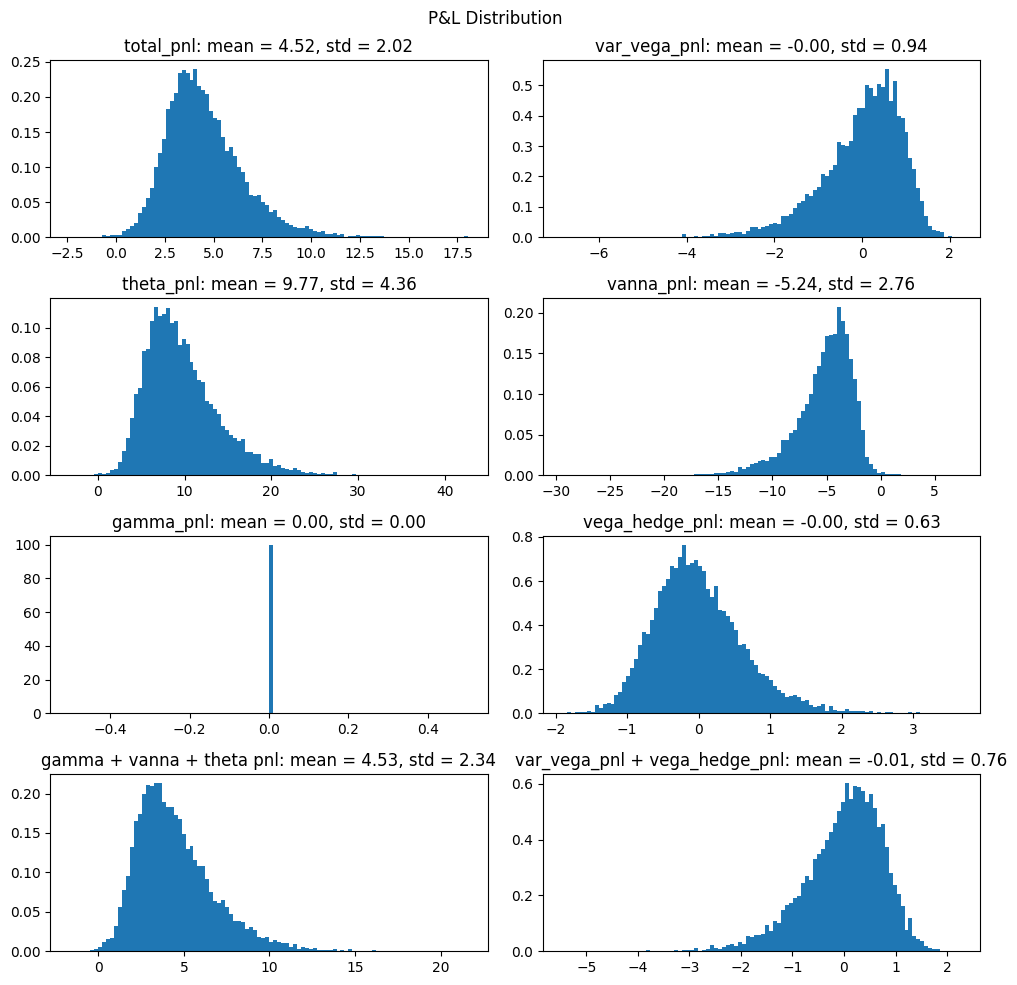

In [12]:
plot_pnl_distribution(fwd_skew_arb_pnl)

- The skewness arbitrage strategy is more profitable with smaller standard deviation than the continuous long strategy.

## Ex Post Sharpe Ratio per DTE

In [13]:
ann_sharpe_per_dte: dict[int, npt.NDArray[np.float64]] = {}

for dte, pnl_calculator in skew_swap_pnl_per_dte.items():
    if dte != 1:
        skew_arb_pnl = pnl_calculator.get_strategy_pnl(skew_arb_strategy) - day_skew_arb_pnl
        ann_sharpe_per_dte[dte] = skew_arb_pnl.total_pnl.mean(axis=0) / (
            skew_arb_pnl.total_pnl.std(axis=0) * np.sqrt(time_delta)
        )

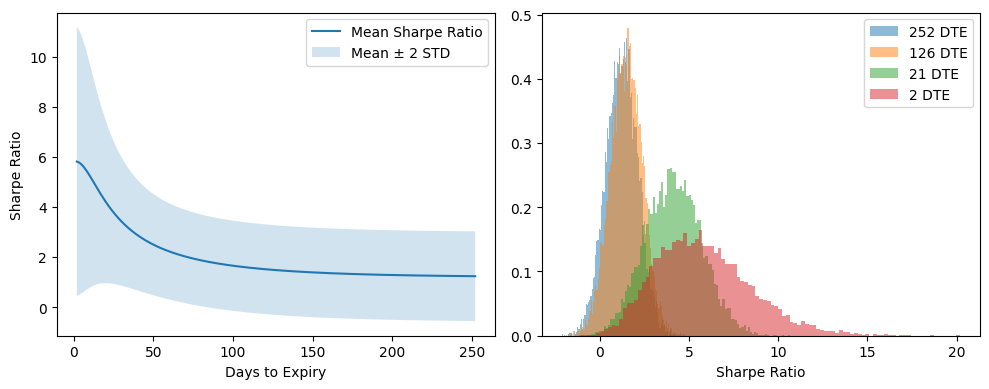

In [14]:
means = [np.mean(ann_sharpe) for ann_sharpe in ann_sharpe_per_dte.values()]
stds = [np.std(ann_sharpe) for ann_sharpe in ann_sharpe_per_dte.values()]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(target_dte[1:], means, label="Mean Sharpe Ratio")
ax[0].fill_between(
    target_dte[1:],
    np.array(means) - 2 * np.array(stds),
    np.array(means) + 2 * np.array(stds),
    alpha=0.2,
    label="Mean ± 2 STD",
)
ax[0].set_xlabel("Days to Expiry")
ax[0].set_ylabel("Sharpe Ratio")
ax[0].legend()

for dte in [BDAYS, 21 * 6, 21, 2]:
    ax[1].hist(
        ann_sharpe_per_dte[dte],
        density=True,
        bins=int(np.sqrt(len(ann_sharpe_per_dte[dte]))),
        label=f"{dte} DTE",
        alpha=0.5,
    )
ax[1].set_xlabel("Sharpe Ratio")
ax[1].legend()

fig.tight_layout()
plt.show()

- Both Vega and Vanna P&L depends on Vega.
- The fact that sharpe gets higher as DTE decreases 